In [1]:
from google.colab import drive
drive.mount('/content/drive')

# Copy dataset from Drive -> Colab (MUCH faster)
!cp -r "/content/drive/MyDrive/Colab Notebooks/new_Facial_Emotion/new_images" /content/new_images

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#1. Importing the Libraries

In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix,classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,BatchNormalization,Dropout,Flatten,Dense
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau


# 1.1 Data Loading and Preprocessing

In [3]:
data_dir="/content/drive/MyDrive/Colab Notebooks/new_Facial_Emotion/new_images"

In [4]:
os.listdir(data_dir)

['Surprise', 'Sad', 'Angry', 'Neutral', 'Happy']

In [5]:
# Image Data Generator

train_datagen=ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

validation_datagen=ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

In [6]:
train_generator=train_datagen.flow_from_directory(
    data_dir,
    target_size=(128,128),
    batch_size=32,
    class_mode="categorical",
    subset="training",
    shuffle=True
)

validation_generator=validation_datagen.flow_from_directory(
    data_dir,
    target_size=(128,128),
    batch_size=32,
    class_mode="categorical",
    subset="validation",
    shuffle=False,

)

Found 11167 images belonging to 5 classes.
Found 2789 images belonging to 5 classes.


#2. EDA

In [7]:
classnames=list(train_generator.class_indices.keys())
classnames

['Angry', 'Happy', 'Neutral', 'Sad', 'Surprise']

In [8]:
train_labels=train_generator.classes
train_labels

array([0, 0, 0, ..., 4, 4, 4], dtype=int32)

In [9]:
number_of_classes=len(train_generator.class_indices)
number_of_classes


5

In [10]:
total_samples=len(train_labels)
total_samples

11167

In [11]:
class_counts = np.bincount(train_labels, minlength=number_of_classes)
print("class counts of training:  ",class_counts)

class counts of training:   [1044 2876 3161 3123  963]


#Class weight formula

## **weight= N/k.nc**   

---> N=total samples    --->  k=number of classes,
                         --->  nc= count of images in each class

In [12]:
class_weights={}
for i in range(number_of_classes):
  nc=class_counts[i]
  class_weights[i]=total_samples/(number_of_classes*nc)



In [21]:
class_weights

{0: np.float64(2.139272030651341),
 1: np.float64(0.7765646731571627),
 2: np.float64(0.7065485605820943),
 3: np.float64(0.7151456932436759),
 4: np.float64(2.3192107995846314)}

#3. Building CNN Model

In [22]:
model=Sequential([
    Conv2D(32,(3,3),1,activation="relu",input_shape=(128,128,3)),
    BatchNormalization(),
    MaxPooling2D(),

    Conv2D(64,(3,3),1,activation="relu"),
    BatchNormalization(),
    MaxPooling2D(),

    Conv2D(128,(3,3),1,activation="relu"),
    BatchNormalization(),
    MaxPooling2D(),

    Conv2D(256,(3,3),1,activation="relu"),
    BatchNormalization(),
    MaxPooling2D(),

    Flatten(),

    Dense(256,activation="relu"),
    Dropout(0.25),

    Dense(5,activation="softmax")

])

In [23]:
model.compile(optimizer="adam",loss="categorical_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     2,359,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,751,173 (10.49 MB)

 Trainable params: 2,750,213 (10.49 MB)

 Non-trainable params: 960 (3.75 KB)

In [24]:
early_stopping=EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
    verbose=1

)

lr_scheduler=ReduceLROnPlateau(
    monitor="val_loss",
    patience=5,
    verbose=1,
    min_lr=1e-6
)

In [25]:
history=model.fit(train_generator,
                  epochs=30,
                  validation_data=validation_generator,
                  class_weight=class_weights,
                  callbacks=[early_stopping,lr_scheduler])

Epoch 1/30
349/349 ━━━━━━━━━━━━━━━━━━━━ 152s 415ms/step - accuracy: 0.2979 - loss: 2.3729 - val_accuracy: 0.3209 - val_loss: 1.4634 - learning_rate: 0.0010
Epoch 2/30
349/349 ━━━━━━━━━━━━━━━━━━━━ 194s 402ms/step - accuracy: 0.4351 - loss: 1.2667 - val_accuracy: 0.4521 - val_loss: 1.2683 - learning_rate: 0.0010
Epoch 3/30
349/349 ━━━━━━━━━━━━━━━━━━━━ 140s 403ms/step - accuracy: 0.4938 - loss: 1.1365 - val_accuracy: 0.5923 - val_loss: 1.0413 - learning_rate: 0.0010
Epoch 4/30
349/349 ━━━━━━━━━━━━━━━━━━━━ 140s 400ms/step - accuracy: 0.5262 - loss: 1.0424 - val_accuracy: 0.5601 - val_loss: 1.0545 - learning_rate: 0.0010
Epoch 5/30
349/349 ━━━━━━━━━━━━━━━━━━━━ 140s 402ms/step - accuracy: 0.5549 - loss: 0.9696 - val_accuracy: 0.5801 - val_loss: 1.0440 - learning_rate: 0.0010
Epoch 6/30
349/349 ━━━━━━━━━━━━━━━━━━━━ 140s 402ms/step - accuracy: 0.5829 - loss: 0.9120 - val_accuracy: 0.6009 - val_loss: 0.9746 - learning_rate: 0.0010
Epoch 7/30
349/349 ━━━━━━━━━━━━━━━━━━━━ 141s 400ms/step - accura

#4. Plot Training Curves

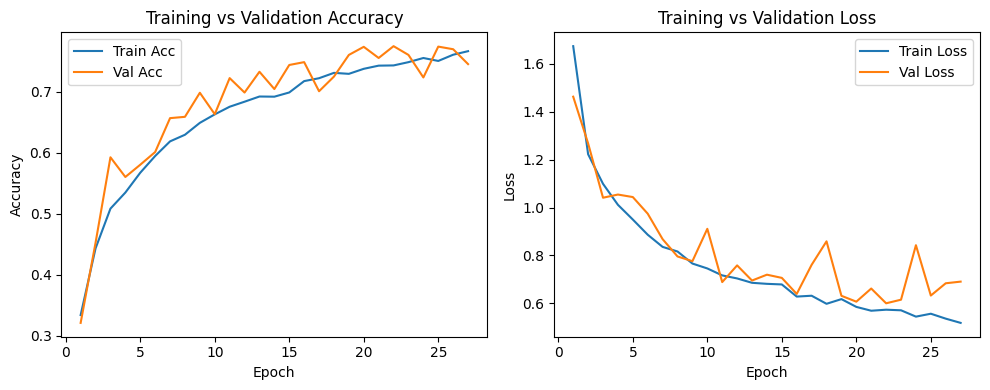

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_ran = range(1, len(acc) + 1)

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(epochs_ran, acc, label='Train Acc')
plt.plot(epochs_ran, val_acc, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs_ran, loss, label='Train Loss')
plt.plot(epochs_ran, val_loss, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()


#4.1. Evaluation

In [52]:
val_step=len(validation_generator)

# step=val_step means asking model to predict all batches from validation
prediction= model.predict(validation_generator,steps=val_step)

y_true=validation_generator.classes
y_pred=np.argmax(prediction,axis=1)

88/88 ━━━━━━━━━━━━━━━━━━━━ 19s 211ms/step


In [87]:
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.72      0.75      0.73       260
           1       0.92      0.90      0.91       719
           2       0.69      0.81      0.74       790
           3       0.74      0.71      0.72       780
           4       0.94      0.54      0.69       240

    accuracy                           0.77      2789
   macro avg       0.80      0.74      0.76      2789
weighted avg       0.79      0.77      0.77      2789



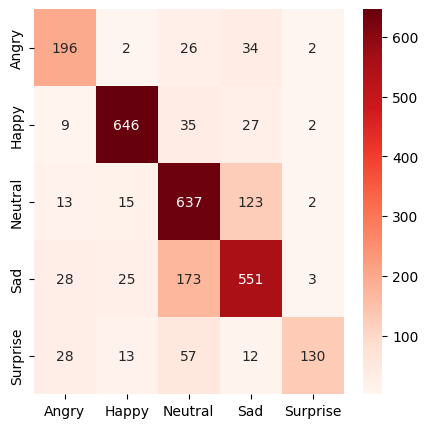

In [53]:
cm=confusion_matrix(y_true,y_pred)
plt.figure(figsize=(5,5))
sns.heatmap(cm,annot=True,fmt="d",cmap="Reds",xticklabels=classnames,yticklabels=classnames)
plt.show()

#5. Predicting New Images

In [72]:
from PIL import Image
from tensorflow.keras.preprocessing import image

In [74]:
def predicting_new_image(image_path):
  original_image=Image.open(image_path)

  img=image.load_img(image_path,target_size=(128,128))
  image_array=image.img_to_array(img)/255.0
  image_array=np.expand_dims(image_array,axis=0)

  prediction=model.predict(image_array)
  predicted_index=np.argmax(prediction)
  predicted_class=classnames[predicted_index]

  confidence=round(prediction[0][predicted_index]*100,2)

  plt.imshow(original_image)
  plt.axis("off")
  plt.title(f"predicted emotion : {predicted_class} - {confidence}")
  plt.show()

  print(f"The Emotion Is {predicted_class} {confidence}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


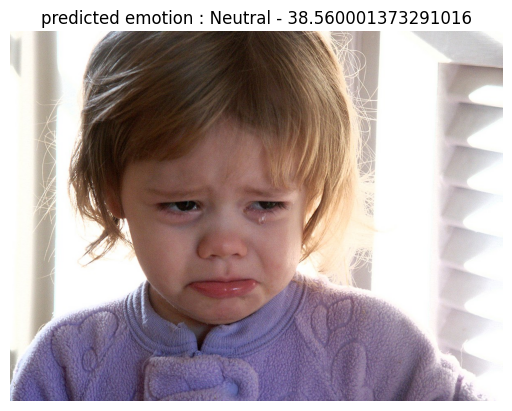

The Emotion Is Neutral 38.560001373291016


In [80]:
predicting_new_image("/content/drive/MyDrive/Colab Notebooks/happy-sad/Crying-girl.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


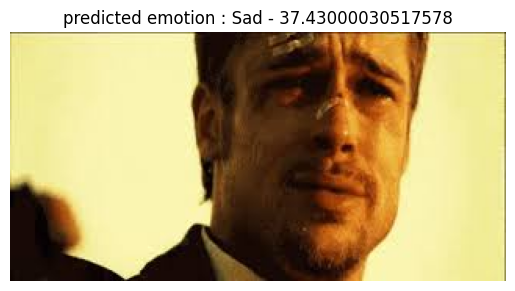

The Emotion Is Sad 37.43000030517578


In [81]:
predicting_new_image("/content/drive/MyDrive/Colab Notebooks/happy-sad/images (1).jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


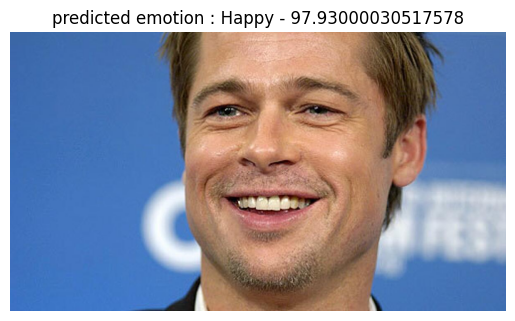

The Emotion Is Happy 97.93000030517578


In [84]:
predicting_new_image("/content/drive/MyDrive/Colab Notebooks/happy-sad/download.jpg")


#6. Save the model

In [88]:
save_path = "/content/drive/MyDrive/Colab Notebooks/new_Facial_Emotion/new_facial_emotion.h5"

In [89]:
model.save(save_path)

In [90]:
!pip freeze > requirements_full.txt


In [91]:
!cp /content/requirements_full.txt "/content/drive/MyDrive/Colab Notebooks/new_Facial_Emotion/requirements_full.txt"
